In [1]:
#digit recognition mnist dataset 2
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#load the data
dataset = pd.read_csv('train.csv')
print dataset.shape
dataset.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
x = dataset.iloc[:,1:].values
y = dataset.iloc[:,0].values.reshape(-1,1)
print x.shape,y.shape

(42000, 784) (42000, 1)


[7]
[5]
[6]
[1]
[7]


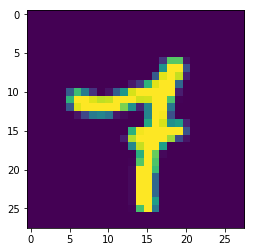

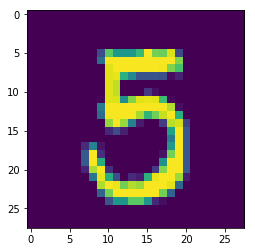

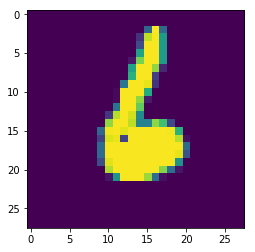

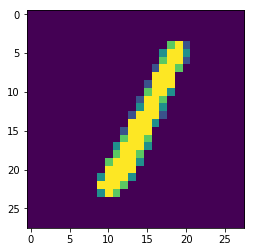

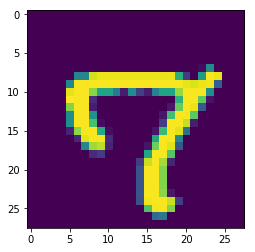

In [4]:
pixel_size = 28
#data visualization
for number in np.random.randint(0,y.shape[0],5):
    temp = x[number,:].reshape(pixel_size,pixel_size)
    print(y[number,:])
    plt.figure()
    plt.imshow(temp)

In [5]:
#PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 300)
x = pca.fit_transform(x)
x.shape

(42000, 300)

In [6]:
#normalization
mean_x = np.mean(x,axis=0,keepdims = True)
sd_x = np.std(x,axis=0,keepdims=True)
x = (x-mean_x)/sd_x
#convert into one hot labels
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
one_hot_labels = ohc.fit_transform(y).toarray()
print x.shape,one_hot_labels.shape

(42000, 300) (42000, 10)


In [7]:
#split into trian and test
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,one_hot_labels,test_size = 0.1)
print "Training set : ",train_x.shape,train_y.shape
print "Testing set : ",test_x.shape,test_y.shape

Training set :  (37800, 300) (37800, 10)
Testing set :  (4200, 300) (4200, 10)


In [8]:
#model
def relu(x):
    return np.maximum(x,0)

def softmax(x):
    return np.exp(-x)/np.sum(np.exp(-x),axis=1,keepdims=True)

def predict(data,weights,n_layers):
    logits = {'a0' : data}
    ##forward propagation
    for i in range(1,n_layers):
        weight = weights["w"+str(i)]
        bias = weights["b"+str(i)]
        prev_a = logits['a'+str(i-1)]
        z = np.dot(prev_a,weight) + bias
        a = relu(z)
        logits['z'+str(i)] = z
        logits['a'+str(i)] = a
    weight = weights['w'+str(n_layers)]
    bias = weights['b'+str(n_layers)]
    prev_a = logits['a'+str(n_layers-1)]
    z = np.dot(prev_a,weight) + bias
    a = softmax(z)
    logits['z'+str(n_layers)] = z
    logits['a'+str(n_layers)] = a
    return logits

def compute_loss(data,labels,weights,n_layers,reg_loss_param=0):
    logits = predict(data,weights,n_layers)
    a = logits['a'+str(n_layers)]
    #computing categorical cross entropy loss
    loss = -np.sum(np.sum(labels*np.log(a)))/labels.shape[0]
    reg_loss = 0
    for key,weight in weights.items():
        if key.startswith('w'):
            reg_loss += np.sum(np.sum(weight**2))
    loss += reg_loss_param*(reg_loss/(2*labels.shape[0]))
    return loss,logits
     
def compute_accuracy(data,labels,weights,n_layers):
    logits = predict(data,weights,n_layers)
    predictions = logits['a'+str(n_layers)]
    val = np.sum(np.argmax(labels,axis=1) == np.argmax(predictions,axis=1))
    return val/labels.shape[0]

In [9]:
#backpropagation
def relu_grad(x):
    temp = np.zeros(x.shape)
    temp[x > 0] = 1.0
    return temp
    
def compute_gradients(logits,labels,weights,n_layers):
    #computing and storing gradients
    grads = {}
    a = logits['a'+str(n_layers)]
    a_prev = logits['a'+str(n_layers-1)]
    de = (labels-a)/labels.shape[0]
    dw = -(np.dot(a_prev.T,de))
    db = -np.sum(de,axis=0,keepdims=True)
    grads['dw'+str(n_layers)] = dw
    grads['db'+str(n_layers)] = db
    for i in np.arange((n_layers-1),0,-1):
        z = logits['z'+str(i)]
        a_prev = logits['a'+str(i-1)]
        w_next = weights['w'+str(i+1)]
        de = np.dot(de,w_next.T)*relu_grad(z)
        dw = -np.dot(a_prev.T,de)
        db = -np.sum(de,axis=0,keepdims=True)
        grads['dw'+str(i)] = dw
        grads['db'+str(i)] = db
    return grads
    
    #updating weights
def update_weights(grads,weights,n_layers,learning_rate,reg_loss_param=0):
    for i in range(1,n_layers+1):
        weights['w'+str(i)] += learning_rate*(grads['dw'+str(i)] +reg_loss_param*(weights['w'+str(i)]))
        weights['b'+str(i)] += learning_rate*grads['db'+str(i)]
    
    return weights

Training loss at step 0 is 2.30
Test accuracy at step 0 is 9.74%


Training loss at step 100 is 2.30
Test accuracy at step 100 is 28.02%


Training loss at step 200 is 2.29
Test accuracy at step 200 is 38.43%


Training loss at step 300 is 2.27
Test accuracy at step 300 is 48.83%


Training loss at step 400 is 2.22
Test accuracy at step 400 is 60.17%


Training loss at step 500 is 2.14
Test accuracy at step 500 is 70.69%


Training loss at step 600 is 1.91
Test accuracy at step 600 is 75.14%


Training loss at step 700 is 1.43
Test accuracy at step 700 is 79.36%


Training loss at step 800 is 0.99
Test accuracy at step 800 is 82.79%


Training loss at step 900 is 0.65
Test accuracy at step 900 is 86.43%


Training loss at step 1000 is 0.52
Test accuracy at step 1000 is 88.60%


Training loss at step 1100 is 0.34
Test accuracy at step 1100 is 89.17%


Training loss at step 1200 is 0.29
Test accuracy at step 1200 is 90.19%


Training loss at step 1300 is 0.29
Test accuracy at step 1300 i

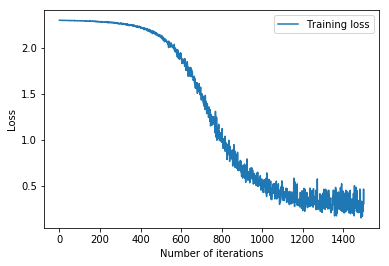

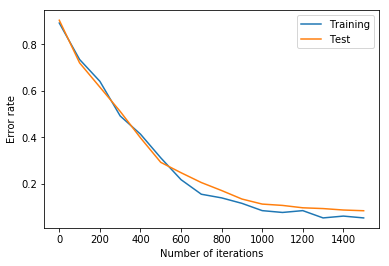

In [10]:
n,m = train_x.shape
#hyperparameters
n_layers = 2
batch_size = 128
n_h = [m,256,10]
learning_rate = 0.02
n_iter = 1501
reg_loss_param = 0.05
#initializing the weights
weights = {}
for i in range(1,(n_layers+1)):
    weights['w'+str(i)] = np.random.randn(n_h[i-1],n_h[i])*0.005
    weights['b'+str(i)] = np.zeros((1,n_h[i]))

    
train_loss = []
train_errs = []
test_errs = []
#training the model
for step in range(n_iter):
    k = (step*batch_size) % (n-batch_size)
    batch_x = train_x[k:(k+batch_size),:]
    batch_y = train_y[k:(k+batch_size),:]
    
    l,logits = compute_loss(batch_x,batch_y,weights,n_layers,reg_loss_param)
    grads = compute_gradients(logits,batch_y,weights,n_layers)
    
    weights = update_weights(grads,weights,n_layers,learning_rate,reg_loss_param)
    train_loss.append(l)
    if step%100 ==0:
        print "Training loss at step %d is %.2f" %(step,l)
        train_err =1.0 - compute_accuracy(batch_x,batch_y,weights,n_layers)
        test_err =1.0 - compute_accuracy(test_x,test_y,weights,n_layers)
        #print "Train accuracy at step %d is %.2f%%"  %(step,100.0*train_acc)
        print "Test accuracy at step %d is %.2f%%" %(step,100.0*(1.0-test_err))
        print '\n'
        train_errs.append(train_err)
        test_errs.append(test_err)

plt.plot(range(n_iter),train_loss,label = 'Training loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_iter,100),train_errs,label = 'Training')
plt.plot(np.arange(0,n_iter,100),test_errs,label = 'Test')
plt.xlabel('Number of iterations')
plt.ylabel('Error rate')
plt.legend()

In [11]:
compute_accuracy(test_x,test_y,weights,n_layers)

0.91452380952380952